Other useful information about this notebook:

- Filename: `dissipation-theory--Study-36.ipynb`
- Continued from: ---
- Continued to: ---

# Preliminaries

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display, Markdown

In [2]:
%matplotlib inline
import matplotlib.pylab as plt

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)
plt.rcParams['figure.figsize'] = 3.25, 3.5

In [3]:
from dissipationtheory.constants import ureg, epsilon0, qe
from dissipationtheory.capacitance import Csphere

In [4]:
THIS = 'dissipation-theory--Study-36--'
figs = {}

# Calculate

In [5]:
class twodimCobject():

    def addsphere(self, r, h, Nz, Nr):
        """Model a sphere of radius $r$ above a ground plane, with a tip-sample
        separation of $h$.  Create image-charge points $r_j$ and voltage-test 
        points $r_k$.  The $N_z$ image-charge points are placed along a verical
        line extending from $h + 0.1 r$ to $h + 1.90 r$. The $N_r$ voltage-test 
        points are located uniformly around the sphere, starting at the south 
        pole, $\theta = -\pi/2$, and rotating counter clockwise. Initialize the
        values of the image charges at 1.0."""

        # convert to nm and strip units
        h = h.to('nm').magnitude
        r = r.to('nm').magnitude

        # charge locations
        delta_array = np.linspace(start=-0.90, stop=0.90, endpoint=True, num=Nz)
        self.rj = np.array([[0, h + r + r * delta] for delta in delta_array])

        # voltage-test locations
        theta_array = np.linspace(start=-np.pi/2, stop=3*np.pi/2, endpoint=False, num=Nr)
        self.rk = np.array([[r * np.cos(theta), h + r + r * np.sin(theta)] for theta in theta_array])
        
        # save these
        self.info = {'type': 'sphere', 'r': r, 'h': h, 'Nz': Nz, 'Nr': Nr }
        self.title1 = f'sphere, $r$ = {r:0.1f} nm, $h$ = {h:0.1f} nm, $N_z$ = {Nz:d}, $N_r$ = {Nr:d}'
        self.title2 = ''

        # initialize the results, useful for plotting
        self.results = {
            'alpha': 0, 
            'q': np.ones(Nz),
            'S': np.ones(Nz),
            'Sinv': np.ones(Nz),
            'cn': 0, 
            'V': np.zeros(Nr),
            'C0': ureg.Quantity(0, 'F'),
            'C1': ureg.Quantity(0, 'F/m'),
            'C2': ureg.Quantity(0, 'F/m^2')}

    def addtip(self, r, h, L, theta):
        """Model a cone-sphere tip above a ground plane.  The tip-sample
        separation is $h$.  The tip radius is $r$, the cone length is $L$,
        and the cone angle is $theta$. The $N_z$ image-charge points and
        the $N_r$ voltage test points are placed following Xu and coworkers, 
        Xu, J.; Li, J.; Li, W. Calculating Electrostatic Interactions in 
        Atomic Force Microscopy with Semiconductor Samples. *AIP Advances* 
        2019, 9(10): 105308, https://doi.org/10.1063/1.5110482."""

        # convert to nm and strip units
        h = h.to('nm').magnitude
        r = r.to('nm').magnitude 
        L = L.to('nm').magnitude

        # convert to radians
        thetar = np.radians(theta)

        dz = r**2/(2 * (r + h))
        d2 = h + r * (1 - np.sin(thetar))
        
        Nt = 3
        Nc = int(np.floor(np.sqrt((L - r) / dz)))
        Nz = Nt + Nc
        
        rj = np.zeros((Nz, 2))
        rj[0,:] = np.array([0, np.sqrt(2 * r * h + h**2)])
        rj[1,:] = np.array([0, h + r - dz])
        rj[2,:] = np.array([0, h + r])
        for k in np.arange(3, Nz):
            rj[k,0] = 0
            rj[k,1] = rj[k-1,1] + dz * (2 * k - 5)
        
        self.rj = rj

        Nr = Nz
        rk = np.zeros((Nr, 2))
        rk[0,:] = np.array([0, h])
        rk[1,:] = np.array([r * np.sin((np.pi/2 - thetar)/2), h + r * (1 - np.cos((np.pi/2 - thetar)/2))])
        rk[2,:] = np.array([r * np.cos(thetar), h + r * (1 - np.sin(thetar))])
        for k in np.arange(3, Nz):
            rk[k,1] = (rj[k,1] + rj[k-1,1])/2 
            rk[k,0] = r * np.cos(thetar) + (rk[k,1] - d2) * np.tan(thetar)

        self.rk = rk
        
        # save these
        self.info = {'type': 'sphere-tipped cone', 'r': r, 'h': h, 'L': L, 'theta': theta, 'Nz': Nz, 'Nr': Nr}
        self.title1 = f'sphere-tipped cone, $r$ = {r:0.1f} nm, $h$ = {h:0.1f} nm, ' \
            f'$L$ = {L:0.1f} nm, $\\theta$ = {theta:0.1f} deg, $N_r$ = {Nr:d}'
        self.title2 = ''

        # initialize the results, useful for plotting
        self.results = {
            'alpha': 0, 
            'q': np.ones(Nz),
            'S': np.ones(Nz),
            'Sinv': np.ones(Nz),
            'cn': 0, 
            'V': np.zeros(Nr),
            'C0': ureg.Quantity(0, 'F'),
            'C1': ureg.Quantity(0, 'F/m'),
            'C2': ureg.Quantity(0, 'F/m^2')}        
        
    def response_metal(self):
        """Creates the response function, the matrix you multiply the charges
        by to get the voltages.  The model below assumes a metallic plane
        at $z = 0$, which gives rise to a set of images charges.  For charges
        in units of $q_e$, the electronic charge, the voltages will be in 
        units of volts.  In the code below, 

            $r_k$ -- voltage-test points
            $r_j$ -- image-charge points
            
        """

        # shorthand
        rk = self.rk
        
        # reverse the z-coordinates to get the locations of the image charges
        rjp = self.rj
        rjm = np.array([self.rj[:,0], -self.rj[:,1]]).T
        
        # unit matrices
        Idk = np.ones_like(rk[:,0])
        Idj = np.ones_like(rjp[:,0])

        # locations of positive and minus (i.e. image) charges
        
        dxp = np.outer(rk[:,0], Idj.T) - np.outer(Idk, rjp[:,0].T)
        dzp = np.outer(rk[:,1], Idj.T) - np.outer(Idk, rjp[:,1].T)
        
        dxm = np.outer(rk[:,0], Idj.T) - np.outer(Idk, rjm[:,0].T)
        dzm = np.outer(rk[:,1], Idj.T) - np.outer(Idk, rjm[:,1].T)

        # compute unitless constant
        V0 = ureg.Quantity(1, 'V')
        x0 = ureg.Quantity(1, 'nm')
        kR = (qe / (4 * np.pi * epsilon0 * V0 * x0)).to('').magnitude

        # response functions
        
        self.R = kR * (np.power(dxp**2 + dzp**2, -1/2) 
                     - np.power(dxm**2 + dzm**2, -1/2))

        self.R1 = kR * 2 * dzm * np.power(dxm**2 + dzm**2, -3/2)

        self.R2 = kR * (4 * np.power(dxm**2 + dzm**2, -3/2)
                          - 12 * dzm**2 * np.power(dxm**2 + dzm**2, -5/2))
        
        # initial voltage guess
        self.results['V'] = np.dot(self.R, self.results['q'])

        # re-use these internal variables
        # locations of positive and minus (i.e. image) charges
        
        dxp = np.outer(rjp[:,0], Idj.T) - np.outer(Idj, rjp[:,0].T)
        dzp = np.outer(rjp[:,1], Idj.T) - np.outer(Idj, rjp[:,1].T)
        
        dxm = np.outer(rjp[:,0], Idj.T) - np.outer(Idj, rjm[:,0].T)
        dzm = np.outer(rjp[:,1], Idj.T) - np.outer(Idj, rjm[:,1].T)        
    
        
        # response functions
        # keep only the reaction term in H0
        
        with np.errstate(divide='ignore'):
            
            self.H0 = - kR * np.power(dxm**2 + dzm**2, -1/2)
            
            self.H1 = kR * 2 * dzm * np.power(dxm**2 + dzm**2, -3/2)

            self.H2 = kR * (4 * np.power(dxm**2 + dzm**2, -3/2)
                              - 12 * dzm**2 * np.power(dxm**2 + dzm**2, -5/2))
            
        # remove inf elements
        
        self.H0[np.isinf(self.H0)] = 0
        self.H1[np.isinf(self.H1)] = 0
        self.H2[np.isinf(self.H2)] = 0
        
    def solve(self, alpha=0.):
        """Solve for the charges.  The parameter $\alpha$ is used to filter
        the singular values in the inverse.         
        """

        U, S, VT = np.linalg.svd(self.R, full_matrices=False)

        filt = np.diag(np.power(S, 2)/(np.power(S, 2) + alpha**2))
        Sinv = filt * np.diag(np.power(S, -1)) 
        Rinv = np.dot(np.dot(VT.T, Sinv), U.T)
              
        IdNr = np.ones(self.info['Nr'])
        q0 = np.dot(Rinv, IdNr)
        q1 = - np.dot(np.dot(np.dot(Rinv, self.R1), Rinv), IdNr) 
        q2 = - np.dot(np.dot(np.dot(Rinv, self.R2), Rinv), IdNr) \
             + 2 * np.dot(np.dot(Rinv, np.dot(self.R1, np.dot(Rinv, np.dot(self.R1, Rinv)))), IdNr)
        
        # save for diagnosis
        self.Rinv = Rinv       
            
        # constants
        V0 = ureg.Quantity(1, 'V')
        x0 = ureg.Quantity(1, 'nm')
        kc0 = (qe / V0).to('aF')
        kc1 = (kc0 / x0).to('F/m')
        kc2 = (kc1 / x0).to('F/m^2')
        
        # derived quantities
        
        self.results['S'] = S                    # unitless
        self.results['Sinv'] = np.diagonal(Sinv) # unitless
        self.results['cn'] = S.max()/S.min()     # unitless
        self.results['q'] = q0                   # units of qe
        self.results['C0'] = kc0 * q0.sum()      # units of F
        self.results['C1'] = kc1 * q1.sum()      # units of F/m
        self.results['C2'] = kc2 * q2.sum()      # units of F/m^2
        self.results['V'] =  np.dot(self.R, q0)  # units of V
        
        # more derived quantities
        
        self.results['c0'] = q0
        self.results['c1'] = q1
        self.results['c2'] = q2

        # recompute the plotting title string
        self.title2 = r'$\alpha$ = {:0.2e}, cn = {:0.2e}, $C_0$ = {:0.4f} aF, $C_1$ = {:0.2e} F/m, $C_2$ = {:0.2e} F/m$^2$'.format(
            self.results['alpha'],
            self.results['cn'], 
            self.results['C0'].to('aF').magnitude,
            self.results['C1'].to('F/m').magnitude,
            self.results['C2'].to('F/m^2').magnitude)
    
    def plot(self, Nj=0, Nr=0):
        """Plot, from left to right, (a) the voltage test points and the computed 
        image charges, (b) the relative voltage error around the object in parts per
        million, (c) image charge value versus position, and (d) singular values 
        for the response-function matrix."""

        if Nj == 0:
            Nj = self.info['Nz']

        if Nr == 0:
            Nr = self.info['Nr']
        
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(8.00, 2.5))
        
        fig.suptitle(self.title1 + '\n' + self.title2, fontsize=10)
    
        cmap = plt.get_cmap('RdBu')
        ax1.scatter(self.rj[0:Nj,0], self.rj[0:Nj,1], 
            marker='.', c=self.results['q'][0:Nj], cmap=cmap, 
            alpha=0.5, edgecolors='face',
            vmin=-max(abs(self.results['q'][0:Nj])), 
            vmax=max(abs(self.results['q'][0:Nj])))
        ax1.scatter(self.rk[0:Nr,0], self.rk[0:Nr,1], marker='.')
        ax1.set_xlabel(r'$\rho$ [nm]')
        ax1.set_ylabel('$z$ [nm]')
        ax1.axis('equal')

        ax2.plot(self.rj[0:Nj,1], self.results['q'][0:Nj], '.-')
        ax2.set_xlabel('$(r_j)_{z}$ [nm]')
        ax2.set_ylabel('$q/q_{e}$')
        ax2.set_title(r''.format(), fontsize=10)
        
        ax3.plot(self.results['V'][0:Nr], '.-')
        ax3.set_xlabel('index')
        ax3.set_ylabel(r'$V$ [V]')
        
        ax4.plot(self.results['S'][0:Nj], label='$\Lambda_k$')
        ax4.plot(self.results['Sinv'][0:Nj], label=r'${\mathrm{filt}}(\Lambda_k^{-1})$')
        ax4.set_xlabel('index $k$')
        ax4.set_ylabel('SVD')
        ax4.set_yscale('log')
        ax4.legend(fontsize=6, frameon=False)
        
        fig.tight_layout()
        
        return fig
    
    def forceA(self, Vts=ureg.Quantity(1, 'V')):
        """Compute the force using the standard capacitance-derivative 
        formula.  Return the force in pN, F1, and the force relative
        to $\pi epsilon_0 V^2}$, F2."""
        
        F1 = (0.5 * self.results['C1'] * Vts**2).to('pN').magnitude
        F2 = ((0.5 * self.results['C1'])/(np.pi * epsilon0)).to('').magnitude
        
        return F1, F2
    
    def forceB(self, Vts=ureg.Quantity(1, 'V')):
    
        V = Vts.to('V').magnitude
        const = (qe * ureg.Quantity(1, 'V') / ureg.Quantity(1, 'nm'))
        
        c0 = V * self.results['c0']
        c1 = V * self.results['c1']
        c2 = V * self.results['c2']
        
        H0 = self.H0
        H1 = self.H1
        H2 = self.H2
        
        Idj = np.ones_like(self.rj[:,0])
         
        f1 = -0.5 * np.dot(c0.T, np.dot(H1, c0))
        
        F1 = ureg.Quantity(const * f1, 'pN')
        F2 = (F1/(np.pi * epsilon0 * Vts**2)).to('').magnitude
        
        return F1.to('pN').magnitude, F2
    
    def forceC(self, Vts=ureg.Quantity(1, 'V')):
    
        V = Vts.to('V').magnitude
        const = (qe * ureg.Quantity(1, 'V') / ureg.Quantity(1, 'nm'))
        
        c0 = V * self.results['c0']
        c1 = V * self.results['c1']
        c2 = V * self.results['c2']
        
        H0 = self.H0
        H1 = self.H1
        H2 = self.H2
        
        Idj = np.ones_like(self.rj[:,0])
        
        f1 = -0.5 * (np.dot(c1.T, np.dot(H0, c0)) 
                   + np.dot(c0.T, np.dot(H1, c0))
                   + np.dot(c0.T, np.dot(H0, c1))) + V * np.dot(Idj.T, c1) 
        
        F1 = ureg.Quantity(const * f1, 'pN')
        F2 = (F1/(np.pi * epsilon0 * Vts**2)).to('').magnitude
        
        return F1.to('pN').magnitude, F2    

In [6]:
Fig3data = pd.read_csv('Xu2019oct--Fig-3--metal.csv', names=['h/r', 'Fnorm'])

In [7]:
r = ureg.Quantity(20, 'nm')
h_array = np.array(Fig3data['h/r']) * r

In [8]:
def calcXu(r, h_array):

    obj = {}
    comp = {}
    forceA = np.zeros_like(h_array)
    forceB = np.zeros_like(h_array)
    forceC = np.zeros_like(h_array)
    
    for key, unit in zip(['C0', 'C1', 'C2'], ['aF', 'pF/m', 'mF/m^2']):
        comp[key] = ureg.Quantity(np.zeros_like(h_array), unit)

    for index, h in enumerate(h_array):

        params = {'r': r,
                  'h': h,
                  'L': ureg.Quantity(4000, 'nm'), 
                  'theta': 15}

        obj['1'] = twodimCobject()
        obj['1'].addtip(**params)
        obj['1'].response_metal()
        obj['1'].solve()

        (_, forceA[index]) = obj['1'].forceA() 
        (_, forceB[index]) = obj['1'].forceB() 
        (_, forceC[index]) = obj['1'].forceC() 
        
        for key in ['C0', 'C1', 'C2']:
            comp[key][index] = obj['1'].results[key]
            
    return obj, comp, forceA, forceB, forceC

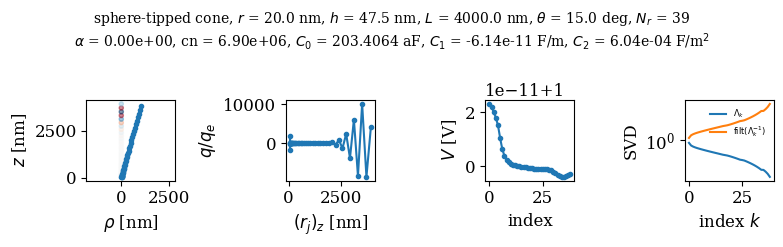

In [41]:
obj, comp, fa, fb, fc = calcXu(r, h_array)
figs['1a'] = obj['1'].plot()

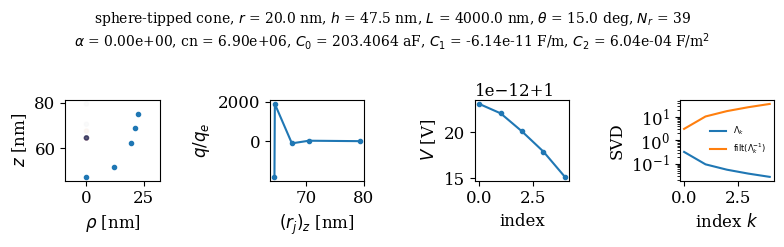

In [42]:
figs['1b'] = obj['1'].plot(Nj=5,Nr=5)

Spot check the forces for the most recent calculation

In [10]:
(obj['1'].forceA(), obj['1'].forceB(), obj['1'].forceC())

((-30.688254478524005, -1.1032491061593013),
 (-30.59120852724775, -1.0997602841060032),
 (-137.88996466828928, -4.957172796357253))

In [11]:
obj['1'].results['c0']

array([-1.80790235e+03,  1.89334979e+03, -1.06439527e+02,  2.68099137e+01,
        4.43810946e+00,  2.10228275e+00,  4.98451198e+00,  4.87431711e+00,
        6.61567826e+00,  7.05911654e+00,  8.48712841e+00,  9.16094337e+00,
        1.04434551e+01,  1.12492290e+01,  1.24546060e+01,  1.33481437e+01,
        1.45203893e+01,  1.54652934e+01,  1.66815965e+01,  1.75296935e+01,
        1.91874664e+01,  1.89933897e+01,  2.33857508e+01,  1.69486411e+01,
        3.55356094e+01, -1.26218520e+00,  8.05907666e+01, -8.27909687e+01,
        2.45053150e+02, -3.80724971e+02,  7.90972888e+02, -1.32496332e+03,
        2.38453757e+03, -3.84988955e+03,  6.08008281e+03, -8.44999453e+03,
        1.00981394e+04, -8.67325270e+03,  4.07378124e+03])

In [12]:
obj['1'].results['c1']

array([ 1.13622760e+01, -1.20105933e+01,  8.95005712e-01, -3.06123309e-01,
       -4.33298409e-03, -1.33957670e-02, -1.81579093e-02, -1.63466457e-02,
       -1.75985706e-02, -1.57948977e-02, -1.58287102e-02, -1.42391776e-02,
       -1.38951919e-02, -1.25945031e-02, -1.21519210e-02, -1.11106058e-02,
       -1.06620852e-02, -9.82609858e-03, -9.40298812e-03, -8.71888929e-03,
       -8.34188388e-03, -7.74071222e-03, -7.48536821e-03, -6.76889751e-03,
       -7.00820208e-03, -5.36737696e-03, -7.70345925e-03, -1.97713299e-03,
       -1.23822569e-02,  8.42136111e-03, -2.96016151e-02,  3.99037638e-02,
       -8.11633755e-02,  1.23132713e-01, -2.01845843e-01,  2.75126388e-01,
       -3.35225398e-01,  2.87001893e-01, -1.40564737e-01])

A table of unitless forces

In [30]:
dg = pd.DataFrame.from_dict(
    {'distance [nm]': h_array.to('nm').magnitude,
     'F norm': Fig3data['Fnorm'],
     'force A': fa,
     'force B': fb,
     'force C': fc})

markdown_table = dg.to_markdown()
display(Markdown(markdown_table))

|    |   distance [nm] |   F norm |   force A |   force B |   force C |
|---:|----------------:|---------:|----------:|----------:|----------:|
|  0 |         4.94665 | -4.57467 |  -4.59654 |  -4.59512 | -31.3021  |
|  1 |         7.46189 | -3.30813 |  -3.30361 |  -3.29992 | -20.2601  |
|  2 |         9.97713 | -2.68431 |  -2.66775 |  -2.66375 | -15.316   |
|  3 |        12.4924  | -2.29679 |  -2.28831 |  -2.28434 | -12.5443  |
|  4 |        17.5229  | -1.862   |  -1.85371 |  -1.84991 |  -9.55657 |
|  5 |        22.4695  | -1.60681 |  -1.61319 |  -1.6095  |  -7.99935 |
|  6 |        27.5     | -1.44612 |  -1.43768 |  -1.43405 |  -6.90648 |
|  7 |        32.4466  | -1.3138  |  -1.32885 |  -1.32527 |  -6.25474 |
|  8 |        37.4771  | -1.22873 |  -1.23099 |  -1.22745 |  -5.68103 |
|  9 |        42.4238  | -1.15312 |  -1.16894 |  -1.16543 |  -5.32708 |
| 10 |        47.5381  | -1.09641 |  -1.10325 |  -1.09976 |  -4.95717 |

In [32]:
print(dg.style.to_latex())

\begin{tabular}{lrrrrr}
 & distance [nm] & F norm & force A & force B & force C \\
0 & 4.946646 & -4.574669 & -4.596544 & -4.595122 & -31.302115 \\
1 & 7.461890 & -3.308129 & -3.303608 & -3.299922 & -20.260110 \\
2 & 9.977134 & -2.684310 & -2.667751 & -2.663747 & -15.316048 \\
3 & 12.492378 & -2.296786 & -2.288311 & -2.284337 & -12.544341 \\
4 & 17.522866 & -1.862004 & -1.853714 & -1.849906 & -9.556566 \\
5 & 22.469512 & -1.606805 & -1.613189 & -1.609496 & -7.999351 \\
6 & 27.500000 & -1.446125 & -1.437680 & -1.434054 & -6.906484 \\
7 & 32.446646 & -1.313800 & -1.328849 & -1.325275 & -6.254738 \\
8 & 37.477134 & -1.228733 & -1.230990 & -1.227450 & -5.681028 \\
9 & 42.423780 & -1.153119 & -1.168943 & -1.165432 & -5.327084 \\
10 & 47.538110 & -1.096408 & -1.103249 & -1.099760 & -4.957173 \\
\end{tabular}



Make a table of the first few effective charges.

In [33]:
dg = pd.DataFrame.from_dict(
    {'$(r_j)_z$ [nm]': obj['1'].rj[0:10,1],
        '$q_{j}/q_e$': obj['1'].results['q'][0:10]})

markdown_table = dg.to_markdown()
display(Markdown(markdown_table))

|    |   $(r_j)_z$ [nm] |   $q_{j}/q_e$ |
|---:|-----------------:|--------------:|
|  0 |          64.5089 |   -1807.9     |
|  1 |          64.5768 |    1893.35    |
|  2 |          67.5381 |    -106.44    |
|  3 |          70.4994 |      26.8099  |
|  4 |          79.3833 |       4.43811 |
|  5 |          94.1897 |       2.10228 |
|  6 |         114.919  |       4.98451 |
|  7 |         141.57   |       4.87432 |
|  8 |         174.145  |       6.61568 |
|  9 |         212.641  |       7.05912 |

In [34]:
print(dg.style.to_latex())

\begin{tabular}{lrr}
 & $(r_j)_z$ [nm] & $q_{j}/q_e$ \\
0 & 64.508885 & -1807.902355 \\
1 & 64.576819 & 1893.349785 \\
2 & 67.538110 & -106.439527 \\
3 & 70.499401 & 26.809914 \\
4 & 79.383274 & 4.438109 \\
5 & 94.189729 & 2.102283 \\
6 & 114.918767 & 4.984512 \\
7 & 141.570386 & 4.874317 \\
8 & 174.144588 & 6.615678 \\
9 & 212.641371 & 7.059117 \\
\end{tabular}



In [43]:
def fig3compare(x1, y1, x2, y2):

    fig, (ax1, ax2) = plt.subplots(2, 1,
        figsize=(3.0, 4.5),
        sharex=True, 
        gridspec_kw={'height_ratios': [1, 3]}) 

    opts1 = {'marker': 'o', 'facecolors': 'none', 'edgecolors': 'black'}
    opts2 = {'marker': '.'}

    ax1.scatter(x1, (y2-y1)/y2, **opts1)
    ax2.scatter(x1, y1, **opts1)
    ax2.scatter(x2, y2, **opts2)
    ax2.plot(x2, y2, '--')

    ax1.set_ylabel('norm. resid.')
    ax2.set_ylabel('norm. force $F / \pi \epsilon_0 V^2$')
    ax2.set_xlabel('norm. separation $h/r$')

    fig.align_ylabels()
    fig.tight_layout()

    return fig

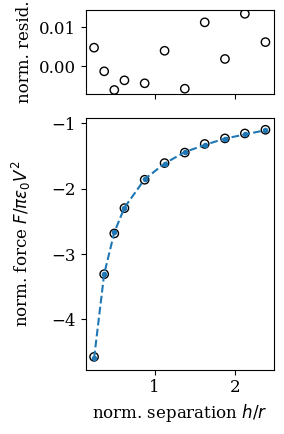

In [44]:
figs['2a'] = fig3compare(
    x1 = Fig3data['h/r'],
    y1 = Fig3data['Fnorm'],
    x2 =(h_array/r).to('').magnitude,
    y2 = fa)

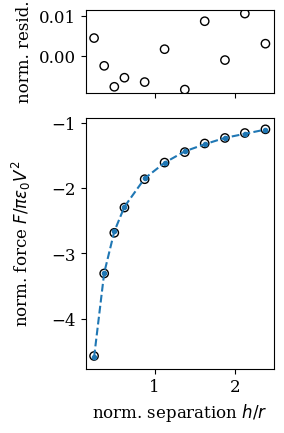

In [45]:
figs['2b'] = fig3compare(
    x1 = Fig3data['h/r'],
    y1 = Fig3data['Fnorm'],
    x2 =(h_array/r).to('').magnitude,
    y2 = fb)

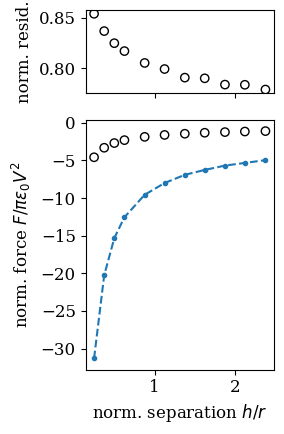

In [46]:
figs['2c'] = fig3compare(
    x1 = Fig3data['h/r'],
    y1 = Fig3data['Fnorm'],
    x2 =(h_array/r).to('').magnitude,
    y2 = fc)

# Save all figures

In [47]:
if 1:
    for num in figs.keys():
        figname = THIS + "Fig-" + num
        figs[num].tight_layout()
        figs[num].savefig(figname + '.png', dpi=300)
        figs[num].savefig(figname + '.pdf')